##### Comparing speed with age
* The Citibike data provides `start station latitude`, `start station longitude`, `end station latitude`, `end station longitude`, geolocation data as well as a `tripduration` in seconds. The cartesian distance was used to calculate the `miles per hour` _effective_ `speed` of someone's trip.
  * The data also includes the year of birth, but it became clear that there is also a lot of fake data,
  ```python
  df = load_data('data/201509_10-citibike-tripdata.csv.annotated.100000.06112016T1814.csv')
  ```
  
  * since from a random sample of `83171` subscriber trips taken in `2015 09` and `2015 10`, there are even people born in `1885`, 
  
  ```python
  In [6]: df['birth year'].describe()
Out[6]: 
count    83171.000000
mean      1977.149680
std         11.400096
min       1885.000000
25%       1969.000000
50%       1980.000000
75%       1986.000000
max       1999.000000
Name: birth year, dtype: float64
  ```
  

  * 


In [7]:
%matplotlib inline
from pipeline_data import load_data
import seaborn as sns
# from plottings import plot_age_speed

/Users/michal/.pyenv/versions/byke/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [16]:
import numpy as np

In [5]:
df = load_data('data/201509_10-citibike-tripdata.csv.annotated.100000.06112016T1814.csv')

* Looking at all the data, the mean speed is around `6mph`.

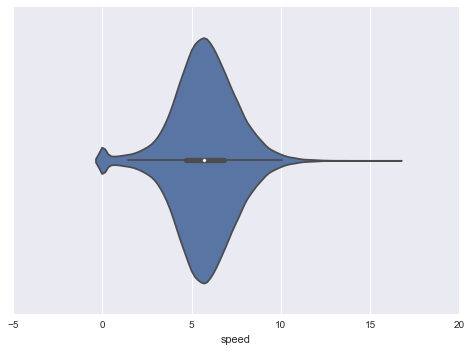

In [10]:
ax = sns.violinplot(x=df['speed'])

In [14]:
def get_age_bucket(age):
    return np.floor(age/10)

In [18]:
df['age_buckets'] = df.age.map(get_age_bucket)

###### For  age buckets from 1 (ages 10-19) and up, we can look at the speeds
* It looks like people riding from `30-39` are most common
```python
df['age_buckets'].value_counts()
Out[19]:
3     27847
2     22417
4     17386
5     10986
6      3492
1       649
7       368
11       16
8         5
13        3
10        2
Name: age_buckets, dtype: int64
```
* And there is also a pattern of the average `speed` going up a bit from `10-19` to `20-49` and then reducing afterwards.

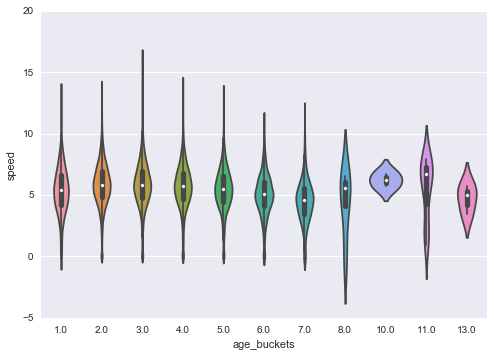

In [29]:
ax2 = sns.violinplot(data=df, x='age_buckets', y='speed')

##### The problem of predicting destination
* The next interesting problem encountered is looking at whether input data can be used to determine where a person is likely to end up, 
* In Citibike data, we have someone's `end station name` and `end station id`. 
* Using the earlier dataset from `September and October 2015`, 

In [33]:
df.shape

(83171, 33)

In [34]:
df['end station id'].value_counts().shape

(392,)

* We have `392` many end stations. Trying to predict a person's exact end station, directly, could easily lead to overfitting the data.
* Instead, the approach used was to make use of *geolocation* data from the Google maps API, to supplement the dataset with `zip code`, `neighborhood` and `sublocality`—a.k.a. `borough`—information. 

###### Approach of gathering geolocation data
* Geolocation code `get_station_geolocation_data.py get_station_geoloc_data()` makes calls to _https://googleapis.com_ , providing text addresses `'end station name'` from the Citibike dataset such as `1st Avenue & E 15th St, NY`—which are zip code and borough amibguous—and the API returns a json representation with matches, 
```python
{
 'raw_result': [{u'address_components': [{u'long_name': u'1st Avenue',
                  u'short_name': u'1st Avenue',
                  u'types': [u'route']},
                 {u'long_name': u'Midtown',
                  u'short_name': u'Midtown',
                  u'types': [u'neighborhood',
                             u'political']},
                 {u'long_name': u'Manhattan',
                  u'short_name': u'Manhattan',
                  u'types': [u'sublocality_level_1',
                             u'sublocality',
                             u'political']},
                 {u'long_name': u'New York',
                  u'short_name': u'New York',
                  u'types': [u'locality',
                             u'political']},
                 {u'long_name': u'New York County',
                  u'short_name': u'New York County',
                  u'types': [u'administrative_area_level_2',
                             u'political']},
                 {u'long_name': u'New York',
                  u'short_name': u'NY',
                  u'types': [u'administrative_area_level_1',
                             u'political']},
                 {u'long_name': u'United States',
                  u'short_name': u'US',
                  u'types': [u'country',
                             u'political']},
                 {u'long_name': u'10003',
                  u'short_name': u'10003',
                  u'types': [u'postal_code']}],
                 u'formatted_address': u'1st Avenue & E 15th St, New York, NY 10003, USA',
                 }
```

* This is parsed to the form, 
```python
{
'geo_results': {'neighborhood': u'Midtown',
                 'postal_code': u'10003',
                 'state': u'NY',
                 'sublocality': u'Manhattan'},
                 }
```
and it is also cached to redis.
* A station dataframe looks like
```
station_name	postal_code	sublocality	neighborhood	state
0	1 Ave & E 15 St	10003	Manhattan	Midtown	NY
1	1 Ave & E 18 St	10003	Manhattan	Midtown	NY
2	1 Ave & E 30 St	10016	Manhattan	Midtown	NY
3	1 Ave & E 44 St	10017	Manhattan	Midtown East	NY
4	1 Ave & E 62 St	10065	Manhattan	Upper East Side	NY
```
* In the code, `annotate_geolocation.py annotate_df_with_geoloc(df, station_df, noisy_nonmatches=False)` was written to join a regular dataset with a `station_df` dataframe.

###### A basic learning strategy is used 
* `sklearn` is used for the investigations
* To do some learning, the input data is chosen, clean up work is necessary to deal with missing data and label encoding is needed to have a format which `sklearn` can work with.